error x2 tensor(190.5690) tensor(24988.7402)
error x2 tensor(60711.5078) tensor(24988.7402)


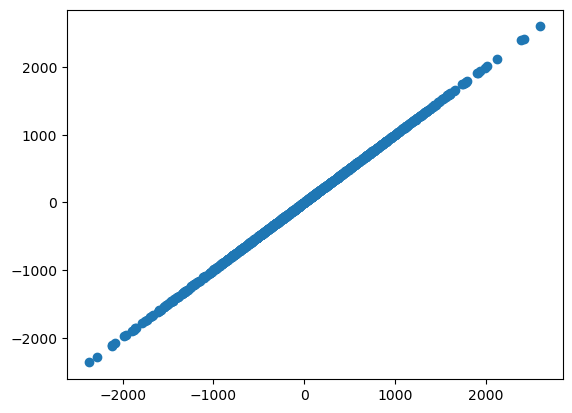

In [10]:
import matplotlib.pyplot as plt
import torch
import utils
import numpy as np
def get_A_b():
    n = 1000
    rand_mat = torch.randn(n, n)
    A = rand_mat @ rand_mat.T  # This creates a symmetric PSD matrix
    #plt.hist(np.linalg.eigvals(A))
    #asdf
    A += torch.eye(n)*1e-1
    b = torch.randn(n)*n
    return A, b
torch.manual_seed(0)
A,b = get_A_b()
x1=utils.solve_linear_psd(A=A,b=b,method='solve')
# print('error x1', (A@x1-b).norm(), x1.norm() ) 

x2=utils.steihaug_toint_cg(A=A,b=b,trust_radius=x1.norm(),max_iter=2000)
print('error x2', (A@x2-b).norm(), x2.norm()) 
print('error x2', (A@x2+b).norm(), x2.norm()) 

# x2=torch.from_numpy(steihaug_toint_cg1(A.numpy(),b.numpy(),x1.norm(),tol=1e-20,max_iter=1000)).float()
# print('error x2', (A@x2-b).norm(), x2.norm()) 
# print('error x2', (A@x2+b).norm(), x2.norm()) 

# x3=torch.from_numpy(steihaug_toint_cg2(A.numpy(),b.numpy(),x1.norm(),tol=1e-20,max_iter=1000)[0]).float()
# print('error x3', (A@x3-b).norm(), x3.norm()) 
# print('error x3', (A@x3+b).norm(), x3.norm()) 

plt.scatter(x1,x2)

In [ ]:
import time, os, argparse
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]='1'

import torch
import utils

utils.set_default_device()



# def get_A_b():
#     n = 1000
#     rand_mat = torch.randn(n, n)
#     A = rand_mat @ rand_mat.T  # This creates a symmetric PSD matrix
#     A += utils.eye_like(A)*1e-4
#     b = torch.randn(n)
#     return A, b

num_runs = 10

for method in ['solve','steihaug']:
    tot_time = 0b
    for i in range(num_runs):
        torch.manual_seed(i)
        A, b = get_A_b()
        kw_args = {} if method != 'steihaug' else dict(trust_radius=10)
        stime = time.time()
        x = utils.solve_linear_psd(A, b, method=method, **kw_args)
        tot_time += time.time() - stime
        utils.empty_cache()
        if True:
            print(x[:4].cpu().numpy())
    print(f'{method:15s} {tot_time:3f}')


In [ ]:
import numpy as np

def steihaug_toint_cg1(A, b, trust_region, tol=1e-6, max_iter=None):
    """
    Steihaug-Toint Conjugate Gradient method for trust-region subproblems.
    
    Solves the trust-region subproblem:
    min (1/2)x^T A x + b^T x  subject to ||x|| <= trust_region
    
    Parameters:
    -----------
    A : numpy.ndarray
        Symmetric matrix, typically the Hessian
    b : numpy.ndarray
        Vector, typically the negative gradient
    trust_region : float
        Radius of the trust region
    tol : float, optional
        Tolerance for convergence
    max_iter : int, optional
        Maximum number of iterations. If None, uses n (dimension of b)
        
    Returns:
    --------
    x : numpy.ndarray
        Solution vector
    """
    n = len(b)
    if max_iter is None:
        max_iter = n
    
    # Initialize
    x = np.zeros(n)      # Initial guess
    g = b.copy()         # Initial gradient (since x=0 and gradient is Ax+b)
    r = -g               # Initial residual (-gradient)
    d = r.copy()         # Initial search direction
    
    # Check for immediate convergence
    r_norm = np.linalg.norm(r)
    if r_norm < tol:
        return x
    
    for i in range(max_iter):
        # Compute curvature
        Ad = A.dot(d)
        dAd = d.dot(Ad)
        
        # Check if we have negative curvature
        if dAd <= 0:
            # Find the boundary point in the direction d
            # Solve for alpha: ||x + alpha*d|| = trust_region
            a = d.dot(d)
            b_quad = 2 * x.dot(d)
            c = x.dot(x) - trust_region**2
            
            # Quadratic formula: (-b + sqrt(b^2 - 4ac)) / 2a
            alpha = (-b_quad + np.sqrt(b_quad**2 - 4*a*c)) / (2*a)
            
            # Return the boundary point
            x = x + alpha * d
            return x
        
        # Standard CG step length
        alpha = r.dot(r) / dAd
        
        # Check if we would exceed the trust region
        x_new = x + alpha * d
        if np.linalg.norm(x_new) >= trust_region:
            # Find the boundary point in the direction d
            a = d.dot(d)
            b_quad = 2 * x.dot(d)
            c = x.dot(x) - trust_region**2
            
            # Quadratic formula: (-b + sqrt(b^2 - 4ac)) / 2a
            alpha = (-b_quad + np.sqrt(b_quad**2 - 4*a*c)) / (2*a)
            
            # Return the boundary point
            x = x + alpha * d
            return x
        
        # Update solution and residual
        x = x_new
        g_new = g + alpha * Ad       # Update gradient
        r_new = -g_new               # Update residual
        
        # Check convergence
        r_new_norm = np.linalg.norm(r_new)
        if r_new_norm < tol:
            return x
        
        # Update direction
        beta = r_new.dot(r_new) / r.dot(r)
        d = r_new + beta * d
        
        # Update for next iteration
        r = r_new
        g = g_new
    
    # Return solution if max iterations reached
    return x

    

In [ ]:
import numpy as np

def steihaug_toint_cg2(A, b, trust_region, tol=1e-6, max_iter=None):
    """
    Steihaug-Toint Conjugate Gradient method for approximately solving the trust-region subproblem:
        min 0.5 * p^T A p + b^T p  subject to ||p|| <= trust_region

    Parameters:
        A : (n, n) ndarray, symmetric (not necessarily positive definite)
        b : (n,) ndarray
        trust_region : float, radius of the trust region
        tol : float, tolerance for convergence
        max_iter : int or None, maximum number of iterations (default: n)

    Returns:
        p : (n,) ndarray, solution vector
        hit_boundary : bool, whether the boundary of the trust region was hit
    """
    n = len(b)
    if max_iter is None:
        max_iter = n

    p = np.zeros(n)
    r = -b.copy()
    d = r.copy()

    norm_r = np.linalg.norm(r)
    if norm_r < tol:
        return p, False

    for k in range(max_iter):
        dAd = d @ A @ d

        if dAd <= 0:
            # Negative curvature or A is indefinite
            tau = _find_tau(p, d, trust_region)
            p = p + tau * d
            return p, True

        alpha = (r @ r) / dAd
        p_new = p + alpha * d

        if np.linalg.norm(p_new) >= trust_region:
            tau = _find_tau(p, d, trust_region)
            p = p + tau * d
            return p, True

        r_new = r - alpha * A @ d

        if np.linalg.norm(r_new) < tol:
            return p_new, False

        beta = (r_new @ r_new) / (r @ r)
        d = r_new + beta * d
        p = p_new
        r = r_new

    return p, False

def _find_tau(p, d, delta):
    """
    Finds tau such that ||p + tau * d|| = delta
    This solves the quadratic equation: ||p + tau*d||^2 = delta^2
    """
    a = np.dot(d, d)
    b = 2 * np.dot(p, d)
    c = np.dot(p, p) - delta**2
    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return 0
    sqrt_disc = np.sqrt(discriminant)
    tau1 = (-b + sqrt_disc) / (2 * a)
    tau2 = (-b - sqrt_disc) / (2 * a)
    tau = max(tau1, tau2)
    return tau
